<a href="https://colab.research.google.com/github/tonyscan6003/CE6003/blob/master/CE6003_example_1_6_mean_shift_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mean Shift Segmentation

In this example we will simply use the sklearn mean shift algorithm https://scikit-learn.org/stable/modules/clustering.html#mean-shift to perform segmentation using by clustering. 
The clustering is peformed on the image in the LUV color space.
As oppsed to clustering with kmeans where the number of clustering centres is chosen a-priori with the mean shift algorithm, the MeanShift "bandwidth" parameter determines the number of cluster centres. This must be chosen by trial and error for a given image.

**Housekeeping:** Import Packages, read image and output both RGB and LUV versions of the image.

In [ ]:
import numpy as np
from sklearn.cluster import MeanShift
from sklearn import preprocessing
import matplotlib.pyplot as plt
import urllib.request
import cv2

In [ ]:
# Function to load image, rescale and output RGB & LUV
sf =3
def url_to_image(url):
   resp = urllib.request.urlopen(url)
   temp_image = np.asarray(bytearray(resp.read()),dtype="uint8")
   temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
   x,y,z = np.shape(temp_image)
   rescale_image = cv2.resize(temp_image, (int(y/sf),int(x/sf)),interpolation=cv2.INTER_CUBIC)
   # Note rgb must be in the range 0->1 in order to properly convert to LUV.
   RGB_image = cv2.cvtColor(rescale_image, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
   Luv_image = cv2.cvtColor(RGB_image, cv2.COLOR_RGB2Luv)
   return Luv_image,RGB_image

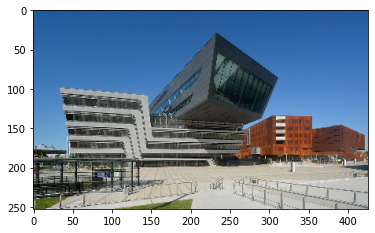

In [ ]:
# read in test image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Campus_WU_LC_D1_TC_DSC_1440w.jpg/1280px-Campus_WU_LC_D1_TC_DSC_1440w.jpg"
Luv_image,RGB_image = url_to_image(image_url)
plt.imshow(RGB_image)



# Plot Feature Space
We will create a 3D plot of the image pixels in LUV color space. The mean shift algorithm aims to find regions of highest density of points which will correspond to the cluster centres.

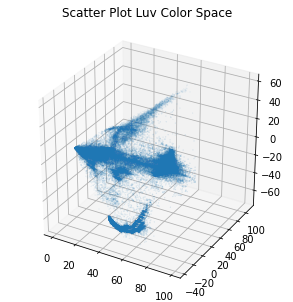

In [ ]:
# PLot Feature Space.
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.scatter(Luv_image[:,:,0], Luv_image[:,:,1], Luv_image[:,:,2],s=0.005)
ax.title.set_text('Scatter Plot Luv Color Space')



# Mean Shift Clustering Algorithm

The sklearn mean shift clustering algorithm is used to perform clustering with LUV color space. 

Note: In the paper by Comaniciu that introducted the segmentation with the mean shift algorithm, spatial information was also included in the determination of cluster centres. This will produce better quality segmentation. However this requires modification of the mean shift algorithm to support joint domains which is not supported by the mean shift algorithm available with scipy.

Comaniciu, D. and Meer, P., 2002. Mean shift: A robust approach toward feature space analysis. IEEE Transactions on pattern analysis and machine intelligence, 24(5), pp.603-619. 


In [ ]:
# Form feature vector from image (form image to n x 3 vector)
x,y,n = np.shape(Luv_image)
luv_feat_vec = np.reshape(Luv_image,(x*y,n))

# Just use 2 channels L,v or u,v for clustering
feat_vec = luv_feat_vec


In [ ]:
# Apply Scipy MeanShift Algotithm
clustering = MeanShift(bandwidth=12,bin_seeding=True).fit(feat_vec)
# Cluster labels and centres
c_lables = clustering.labels_
c_centres = clustering.cluster_centers_
# Determine which pixels are allocated to which cluster centres.
allocated_centres=clustering.predict(feat_vec)

In [ ]:
# Assign the cluster centre value to pixels in each cluster.
# Values are assigned as Luv convert to RGB at later point
ptr = 0
col_vec = np.zeros((x*y,n))
for cc in allocated_centres:
   col_vec[ptr,0:3] =  c_centres[cc]
   ptr +=1
# Segmented image
seg_img = np.reshape(col_vec,(x,y,n))

In [ ]:
#convert Luv values from seg img back into RGB
seg_img_rgb=cv2.cvtColor(seg_img.astype(np.float32), cv2.COLOR_Luv2RGB)

(-0.5, 425.5, 252.5, -0.5)

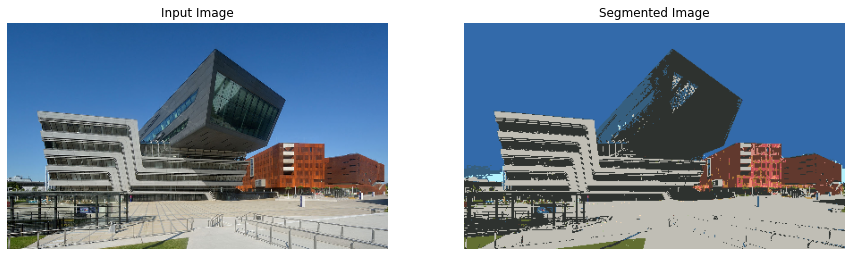

In [ ]:
#Plot segmented image
f, axarr = plt.subplots(1,2,figsize=(15,11))
axarr[0].imshow(RGB_image)
axarr[0].title.set_text('Input Image')
axarr[0].axis('off')
axarr[1].imshow((seg_img_rgb))
axarr[1].title.set_text('Segmented Image')
axarr[1].axis('off')
